Scene cut detected at frame 8 with score: 0.8747441977078924
Scene cut detected at frame 12 with score: 0.829008357533604
Scene cut detected at frame 26 with score: 0.8986449207058375
Scene cut detected at frame 74 with score: 0.8856961277710997
Scene cut detected at frame 89 with score: 0.877416270076503
Scene cut detected at frame 105 with score: 0.8685724364978747
Scene cut detected at frame 221 with score: 0.8981418392194273
Scene cut detected at frame 239 with score: 0.6599874481194539
Scene cut detected at frame 257 with score: 0.881463357911643
Scene cut detected at frame 276 with score: 0.8810387486322588
Scene cut detected at frame 353 with score: 0.8030571903252377
Scene cut detected at frame 372 with score: 0.7458760627741954
Scene cut detected at frame 444 with score: 0.8648375062652938
Soft cut detected at frame 4 with mean difference: 29.491848958333332
Soft cut detected at frame 170 with mean difference: 31.09273871527778
Soft cut detected at frame 187 with mean differen

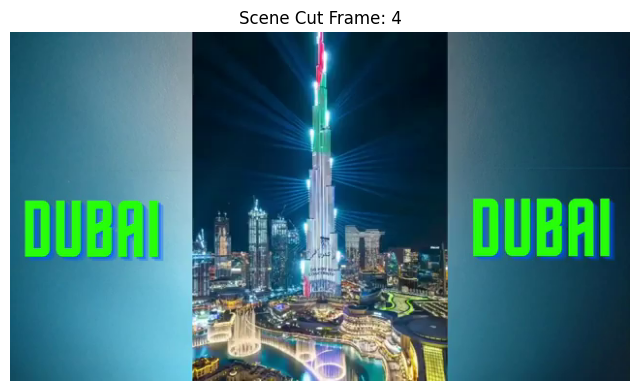

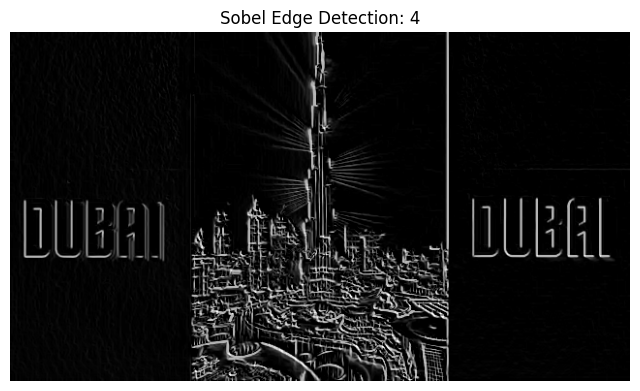

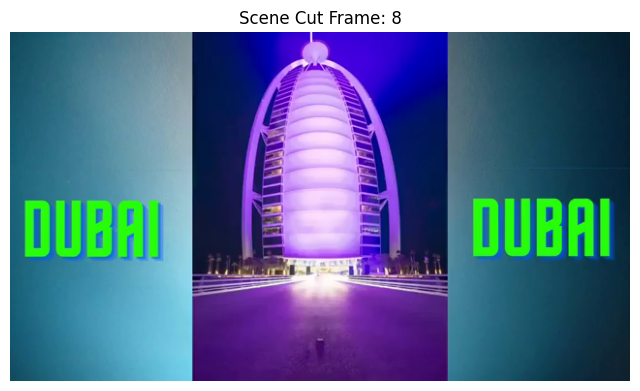

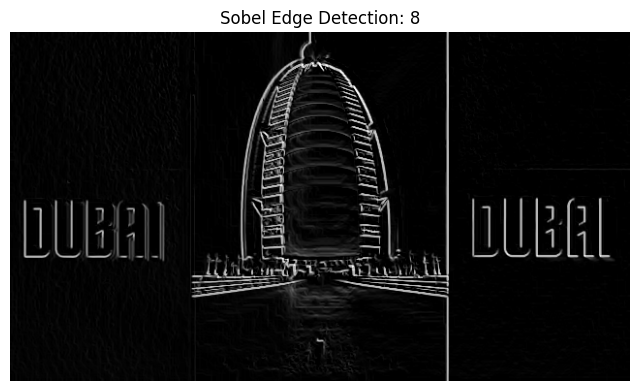

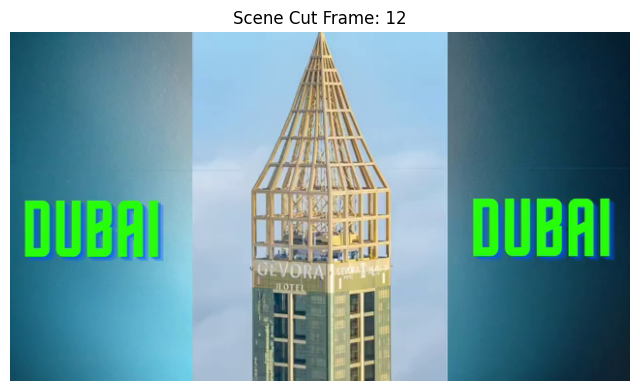

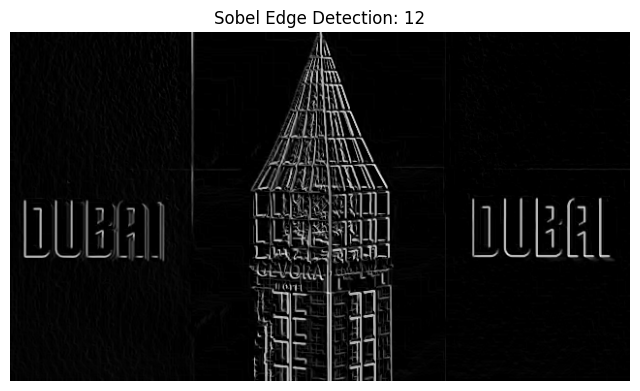

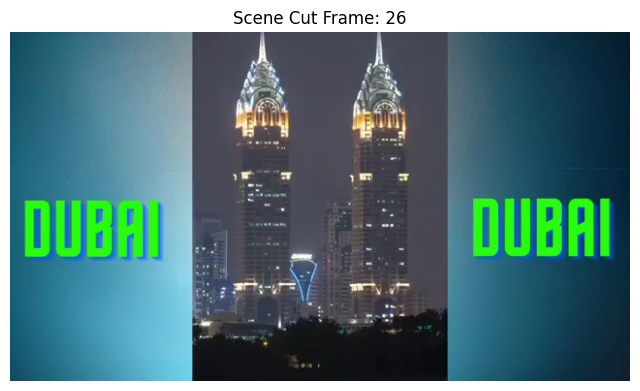

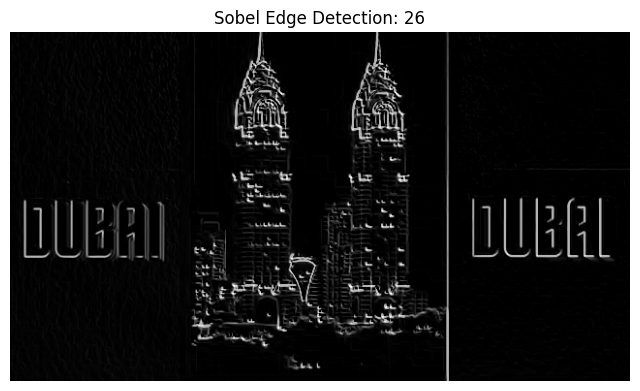

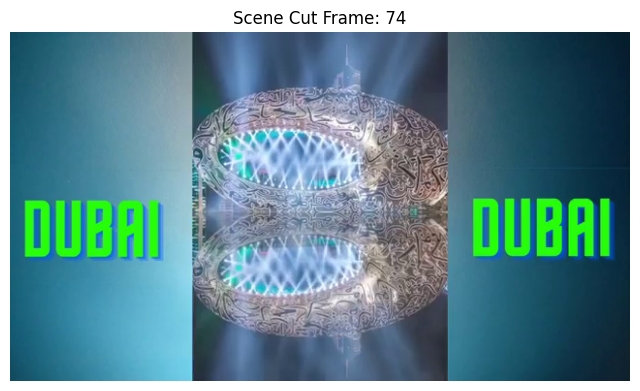

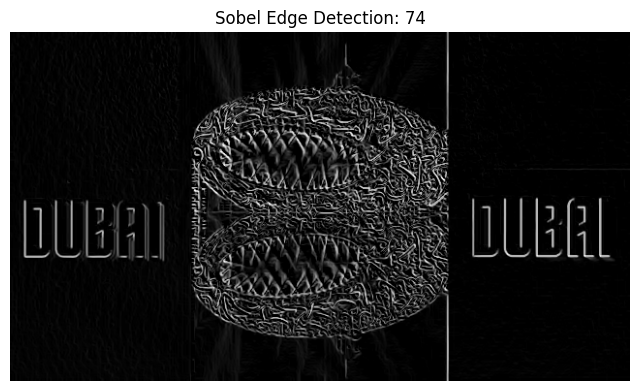

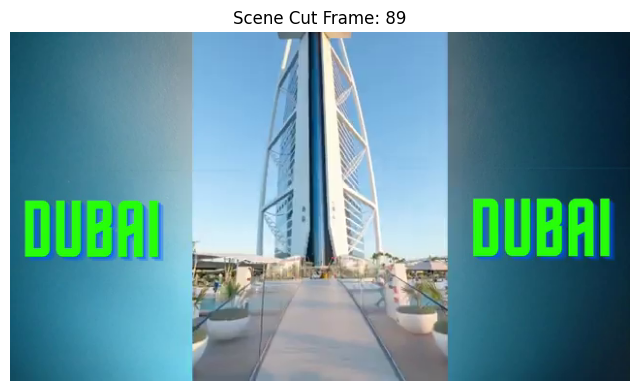

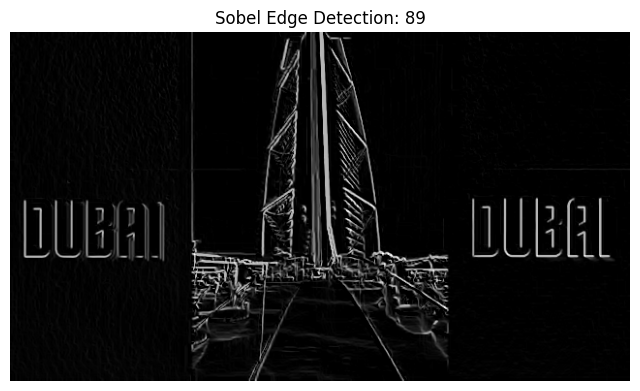

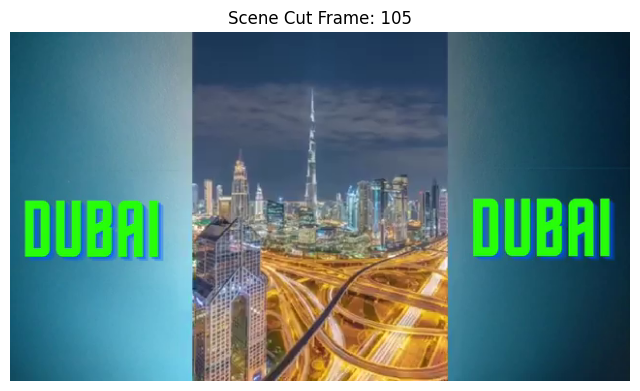

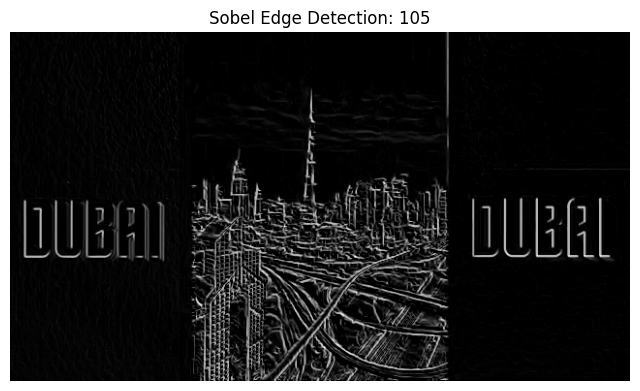

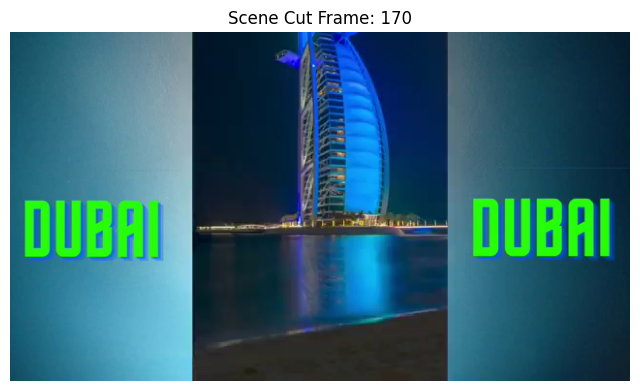

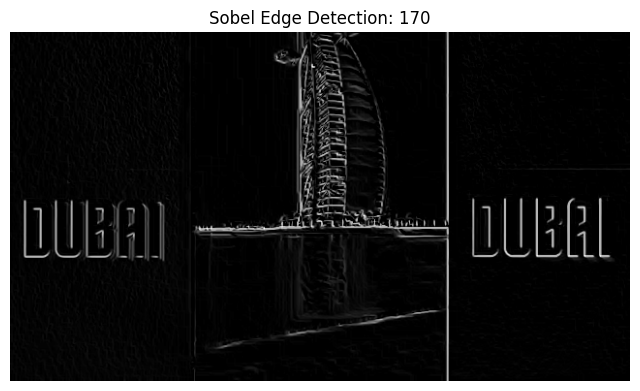

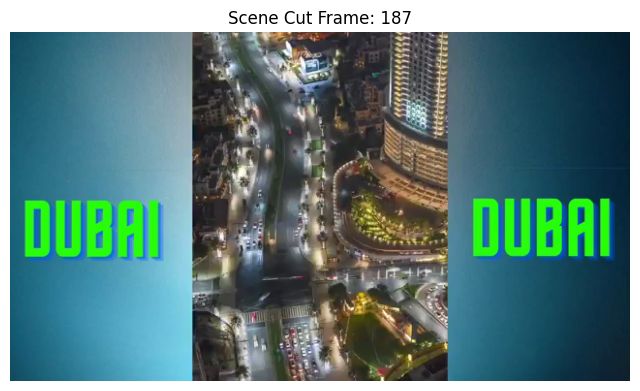

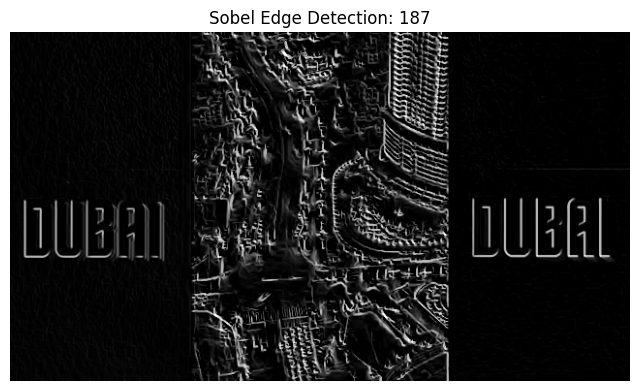

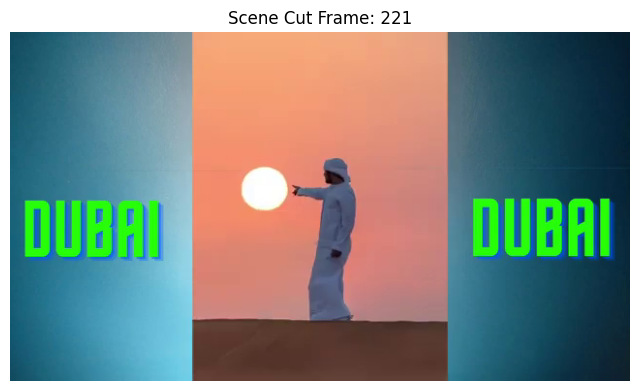

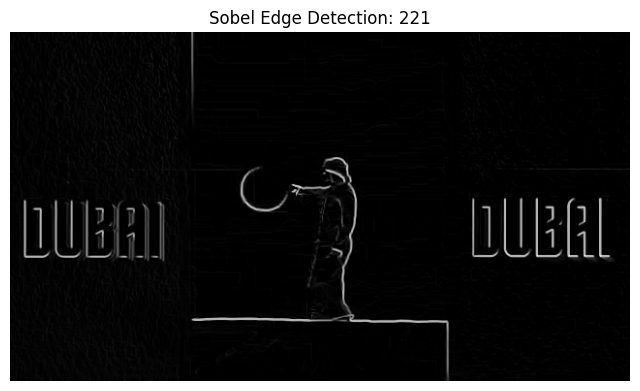

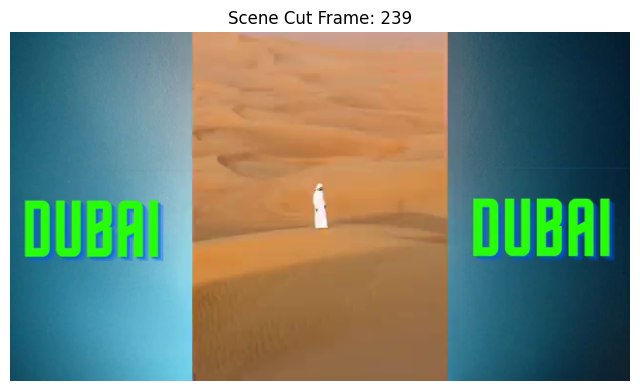

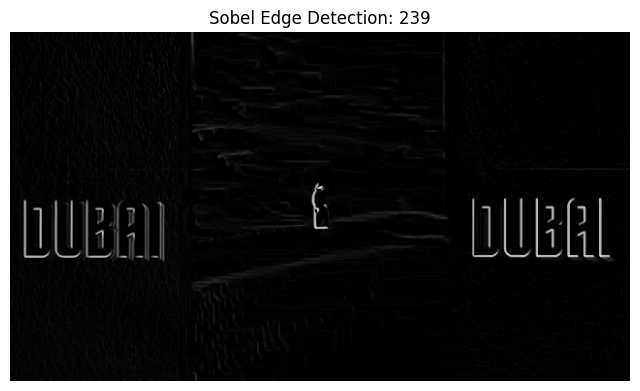

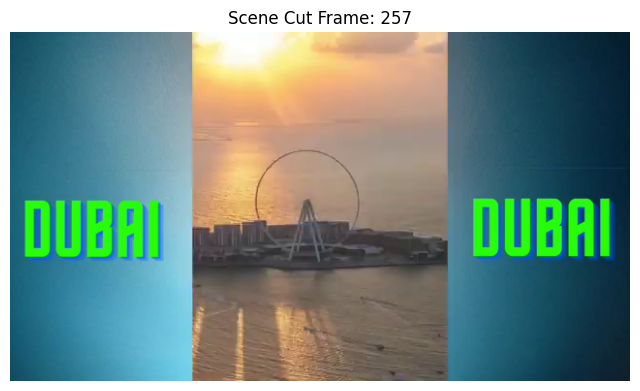

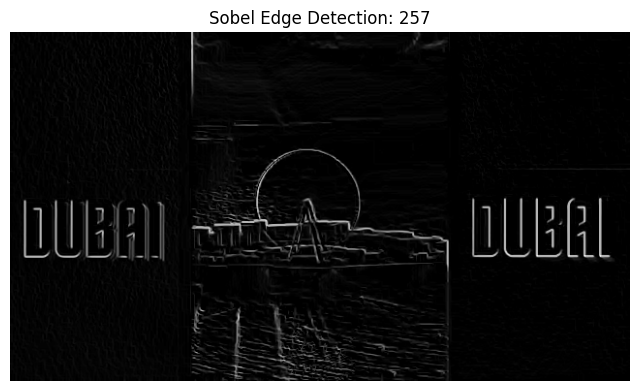

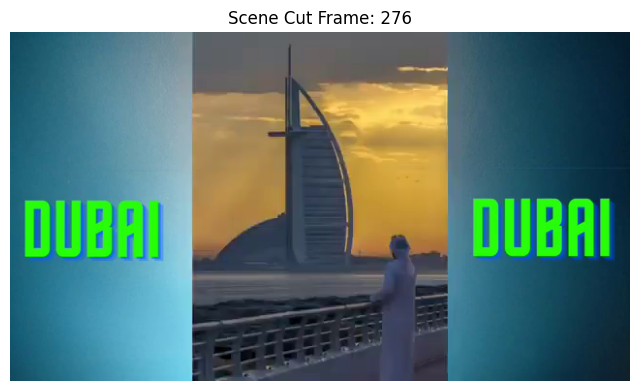

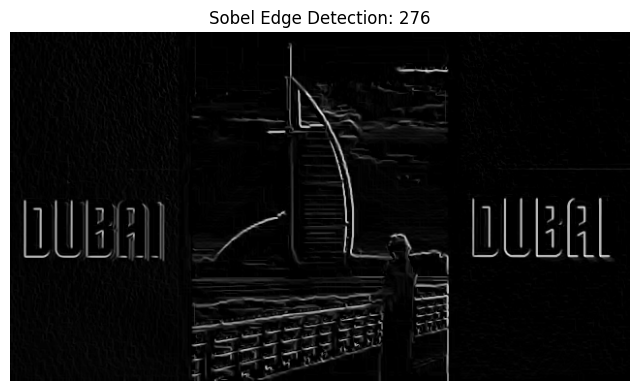

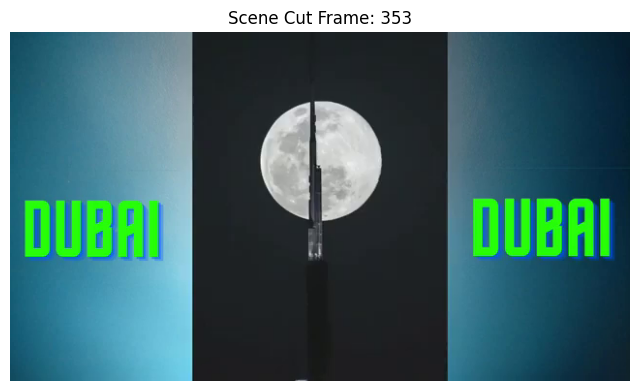

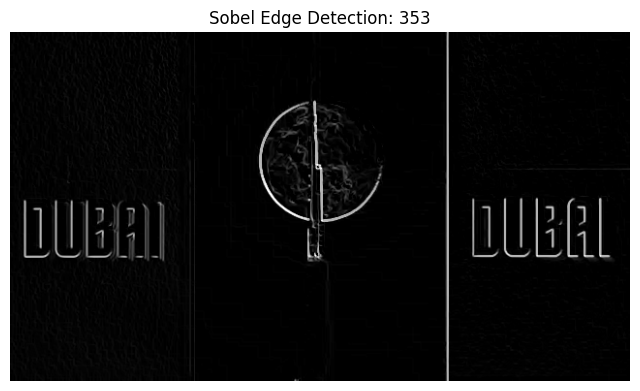

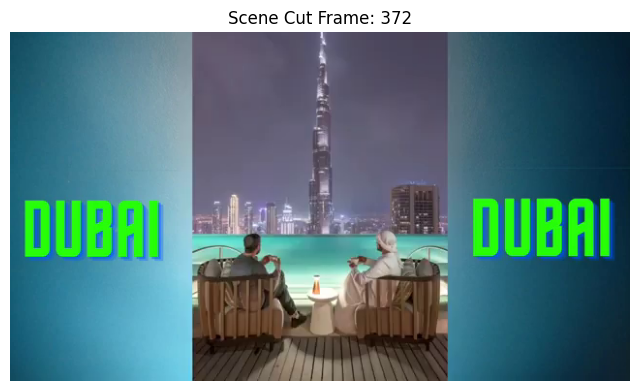

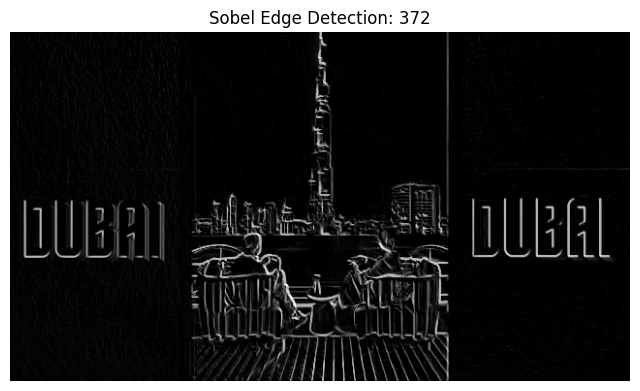

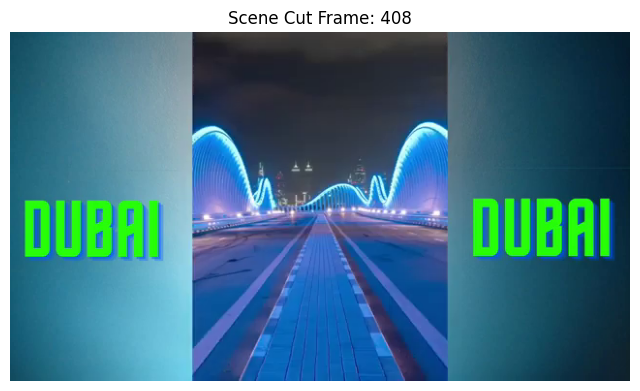

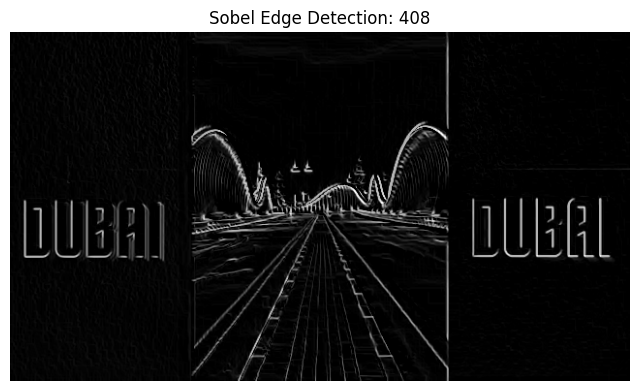

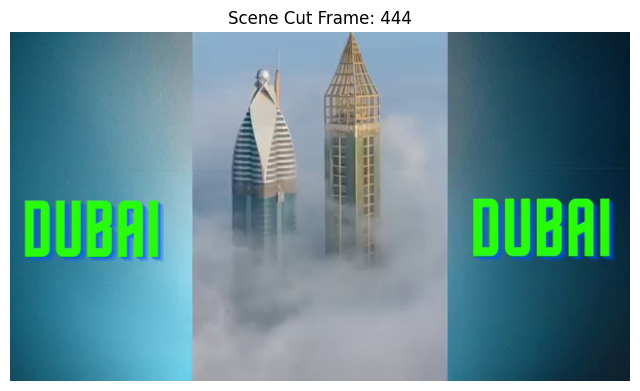

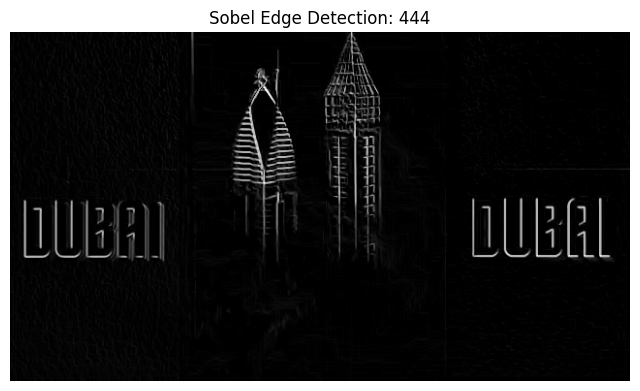

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Paths
video_path = r"/content/video.mp4"
frames_path = r"/content/frames"

# Create frames directory if it doesn't exist
if not os.path.exists(frames_path):
    os.makedirs(frames_path)

# Convert video to frames
cap = cv2.VideoCapture(video_path)
frames = []
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
    frame_count += 1

cap.release()

# Convert frames to HSV
def convert_to_hsv(frames):
    return [cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) for frame in frames]

hsv_frames = convert_to_hsv(frames)

# Noise reduction
def noise_reduction(frame):
    kernel = np.ones((5, 5), np.float32) / 25
    return cv2.filter2D(frame, -1, kernel)

def denoise_frames(frames):
    return [noise_reduction(frame) for frame in frames]

denoised_frames = denoise_frames(hsv_frames)

# Modified: Ensure histograms are in float32
def calculate_histogram(frame):
    hist = np.zeros((256, 3), dtype=np.float32)
    for i in range(3):
        hist[:, i] = cv2.calcHist([frame], [i], None, [256], [0, 256]).astype(np.float32).flatten()
    return hist

# Hard cut detection (using histogram correlation)
def detect_scene_cuts(frames, threshold=0.9):
    previous_hist = None
    scene_cut_frames = []
    for idx, frame in enumerate(frames):
        hist = calculate_histogram(frame)
        if previous_hist is not None:
            # Calculate correlation between current and previous frame histograms
            score = max(cv2.compareHist(previous_hist, hist, cv2.HISTCMP_CORREL), 0)
            if score < threshold:
                print(f"Scene cut detected at frame {idx} with score: {score}")
                scene_cut_frames.append(idx)
        previous_hist = hist
    return scene_cut_frames

# Soft cut detection (based on frame intensity differences)
def detect_soft_cuts(frames, threshold=25.0):
    soft_cut_frames = []
    previous_frame = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    for idx in range(1, len(frames)):
        current_frame = cv2.cvtColor(frames[idx], cv2.COLOR_BGR2GRAY)
        # Measure frame-to-frame intensity difference
        diff = cv2.absdiff(current_frame, previous_frame)
        mean_diff = np.mean(diff)
        if mean_diff > threshold:
            print(f"Soft cut detected at frame {idx} with mean difference: {mean_diff}")
            soft_cut_frames.append(idx)
        previous_frame = current_frame
    return soft_cut_frames

# Sobel edge detection
def sobel_filters(image):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = cv2.filter2D(image, -1, Kx)
    Iy = cv2.filter2D(image, -1, Ky)
    G = np.hypot(Ix, Iy)
    G_max = G.max()
    if G_max > 0:
        G = G / G_max * 255
    else:
        G = np.zeros_like(G)
    return G

def sobel_edge_detection(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edge_frame = sobel_filters(gray)
    return edge_frame

# Detect Scene Cuts with adjusted thresholds
hard_cut_frames = detect_scene_cuts(denoised_frames, threshold=0.9)
soft_cut_frames = detect_soft_cuts(denoised_frames, threshold=25.0)

# Combine hard and soft cut frames
scene_cut_frames = sorted(set(hard_cut_frames + soft_cut_frames))

# Process and display only scene cut frames with Sobel edge detection
for cut_frame in scene_cut_frames:
    cut_image = frames[cut_frame]

    # Apply Sobel edge detection
    edge_frame = sobel_edge_detection(cut_image)

    # Convert BGR to RGB for displaying
    cut_image_rgb = cv2.cvtColor(cut_image, cv2.COLOR_BGR2RGB)

    # Plot the original scene cut frame
    plt.figure(figsize=(8, 6))
    plt.imshow(cut_image_rgb)
    plt.title(f"Scene Cut Frame: {cut_frame}")
    plt.axis('off')
    plt.show()

    # Plot the Sobel edge-detected frame
    plt.figure(figsize=(8, 6))
    plt.imshow(edge_frame, cmap='gray')
    plt.title(f"Sobel Edge Detection: {cut_frame}")
    plt.axis('off')
    plt.show()
